# MNIST Image Classification

MNIST ("Modified National Institute of Standards and Technology") is the de facto “Hello World” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this classification, we aim to correctly identify digits from a dataset of tens of thousands of handwritten images by using the Convolutional Neural Network(PyTorch)

# Import the Libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

## Loading the Dataset from TorchVision

In [2]:
from torchvision import datasets, transforms
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [5]:
len(train_data)

60000

In [6]:
test_data = datasets.MNIST(root='', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


From the above result we can see that the dimension of the image is ``1 x 28x 28`` which indicates that the ``height = 28``, ``widith  = 28`` and ``color channel is 1`` which is black and white

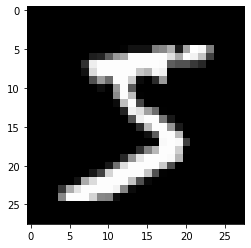

In [8]:
plt.imshow(train_data[0][0].reshape(28,28),cmap='gray')

# Data Loading Strategy

As there are more than 30k rows its not wise to feed all the data once into the CNN model. Instead we will try to feed the data in batches to the model using Dataset and DataLoader feature of Torch library

In [8]:
from torch.utils.data import TensorDataset, DataLoader

In [9]:
"""
Initializing train/test dataloader object which splits the training dataset into small batches of 10 images each
and this can be used later in the CNN model  
"""
torch.manual_seed(101)
bat_sz=10
train_loader = DataLoader(train_data,batch_size=bat_sz,shuffle=True)
test_loader = DataLoader(test_data,batch_size=bat_sz,shuffle=False)

# Define the CNN Model

In [10]:
class CONVNN(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1  = nn.Conv2d(1, 10 , 3 , 1)# We will ne using 3X3 filter/kernel and stride of 1 without any padding as MNIST images re centered and don't have any info at the border/edges
        self.conv2  = nn.Conv2d(10, 16, 3 , 1)
        self.layer1 = nn.Linear(16*5*5,120) # we need to calculate the resulting number of matrices passing thru the conv layer and put that corressponding o/p as the linear layer input
        self.layer2 = nn.Linear(120,84)
        self.layer3 = nn.Linear(84,10)
        
    def forward(self,x):
        
        x= F.max_pool2d(  F.relu(self.conv1(x)) , 2, 2) #adding relu and max pooling the same line
        x= F.max_pool2d(  F.relu(self.conv2(x)) , 2, 2) #adding relu and max pooling the same line
        x= F.relu(self.layer1(x.view(-1,16*5*5))) #flattening by using View and no dropout has been added
        x= F.relu(self.layer2(x))
        x= F.log_softmax(self.layer3(x),dim=1) #multiclass classificaiton
        
        return x
    

In [11]:
torch.manual_seed(101)
model = CONVNN()
model

CONVNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (layer1): Linear(in_features=400, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=10, bias=True)
)

# Define Loss and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Training the CNN Model

In [13]:
epochs = 9
train_loss= []
test_loss= []
train_acc=[]
test_acc = []

print(f'\nConvolutional Neural Network Model Metrics:\n')
print(f'\t This CNN model configuration has {epochs} epochs with each batch size of {bat_sz} images:\n')
for i in range(epochs):
    
    train_crt_pred = 0
    test_crt_pred = 0
    conf_mat= torch.FloatTensor([])
    
    for b,(x_train,y_train) in enumerate (train_loader):
        b += 1
        y_pred = model.forward(x_train)
        loss= criterion(y_pred,y_train)
        
        buffer = torch.max(y_pred.data, 1) [1]
        batch_acc = (buffer == y_train).sum()
        train_crt_pred +=  batch_acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        if b%300 == 0:
            print(f'Epoch{i+1:2} Batch {b:4} loss: {loss.item():5.2f} Train Accuracy: {train_crt_pred.item()*100/(bat_sz*b):6.3f}%')
    
    train_loss.append(loss)  #loss after 1 epoch
    train_acc.append(train_crt_pred) # crt predictions after 1 epoch
    
    
    with torch.no_grad():  #testing after 1 complete epoch
        for b,(x_test,y_test) in enumerate (test_loader):
            b += 1
            y_eval = model.forward(x_test)
            loss= criterion(y_eval,y_test)
            buffer1 = torch.max(y_eval.data, 1) [1]
            conf_mat =  torch.cat((conf_mat.float(),buffer1.float()),0)
            batch_acc = (buffer1 == y_test).sum()
            test_crt_pred +=  batch_acc
    
    test_loss.append(loss) #test loss after the last completed epoch
    test_acc.append(test_crt_pred) # crt predictions using the last completed epoch

    print(f'After {i+1} Epoch the Train Accuracy is {(train_crt_pred.item()/len(train_data))*100:6.3f}% and Test Accuracy is {(test_crt_pred.item()/len(test_data))*100:6.3f}% \n')     
    
        


Convolutional Neural Network Model Metrics:

	 This CNN model configuration has 9 epochs with each batch size of 10 images:

Epoch 1 Batch  300 loss:  0.34 Train Accuracy: 67.967%
Epoch 1 Batch  600 loss:  0.12 Train Accuracy: 79.150%
Epoch 1 Batch  900 loss:  0.24 Train Accuracy: 83.833%
Epoch 1 Batch 1200 loss:  0.12 Train Accuracy: 86.492%
Epoch 1 Batch 1500 loss:  0.01 Train Accuracy: 88.140%
Epoch 1 Batch 1800 loss:  0.17 Train Accuracy: 89.333%
Epoch 1 Batch 2100 loss:  0.04 Train Accuracy: 90.329%
Epoch 1 Batch 2400 loss:  0.01 Train Accuracy: 91.025%
Epoch 1 Batch 2700 loss:  0.03 Train Accuracy: 91.626%
Epoch 1 Batch 3000 loss:  0.02 Train Accuracy: 92.147%
Epoch 1 Batch 3300 loss:  0.01 Train Accuracy: 92.497%
Epoch 1 Batch 3600 loss:  0.01 Train Accuracy: 92.889%
Epoch 1 Batch 3900 loss:  0.23 Train Accuracy: 93.195%
Epoch 1 Batch 4200 loss:  0.00 Train Accuracy: 93.481%
Epoch 1 Batch 4500 loss:  0.05 Train Accuracy: 93.729%
Epoch 1 Batch 4800 loss:  0.02 Train Accuracy: 93

# Model Evaluation

In [14]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import confusion_matrix,classification_report

In [15]:
print('\nThe Confusion Matrix is plotted below:')
display(pd.DataFrame(confusion_matrix(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1),labels=[0,1,2,3,4,5,6,7,8,9]),index=[0,1,2,3,4,5,6,7,8,9],columns=[0,1,2,3,4,5,6,7,8,9]))
print('\nThe Classification Report is plotted below: \n\n',classification_report(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1)))



The Confusion Matrix is plotted below:


,0,1,2,3,4,5,6,7,8,9
0,971,0,1,0,0,1,2,2,1,2
1,0,1128,0,2,0,1,2,1,1,0
2,1,0,1021,0,1,0,2,7,0,0
3,0,0,1,999,0,8,0,0,2,0
4,1,0,0,0,970,0,3,1,0,7
5,1,0,1,6,0,883,1,0,0,0
6,3,2,0,0,1,4,947,0,1,0
7,0,3,2,2,0,0,0,1019,0,2
8,3,0,2,2,0,1,0,0,965,1
9,0,0,0,4,3,3,0,1,3,995



The Classification Report is plotted below: 

               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       980
         1.0       1.00      0.99      0.99      1135
         2.0       0.99      0.99      0.99      1032
         3.0       0.98      0.99      0.99      1010
         4.0       0.99      0.99      0.99       982
         5.0       0.98      0.99      0.98       892
         6.0       0.99      0.99      0.99       958
         7.0       0.99      0.99      0.99      1028
         8.0       0.99      0.99      0.99       974
         9.0       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



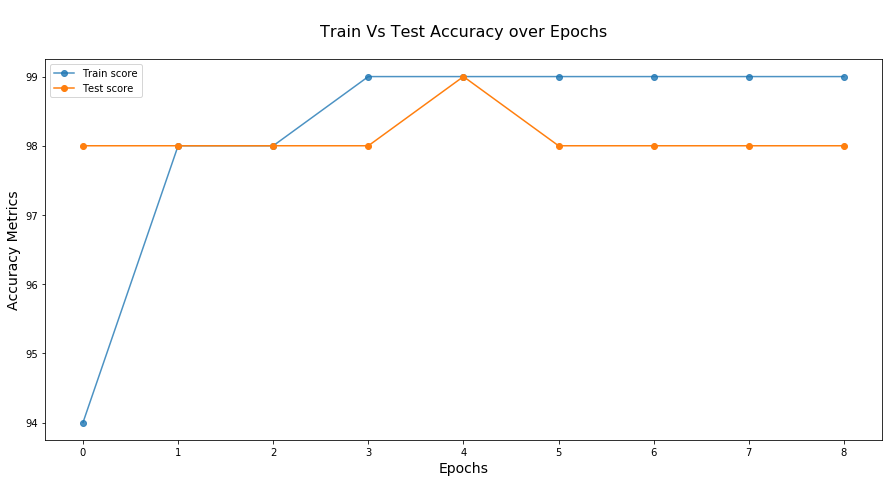

In [16]:
plt.figure(figsize=(15,7))
plt.plot([t/600 for t in train_acc], label='Train score',marker='o',alpha=0.8)
plt.plot([t/100 for t in test_acc], label='Test score',marker='o')
plt.title('\nTrain Vs Test Accuracy over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy Metrics',fontsize=14)
plt.legend();

From above we can see that, at the epoch 5 we have better Test results hence it is wise to stop the training at 5th epoch 

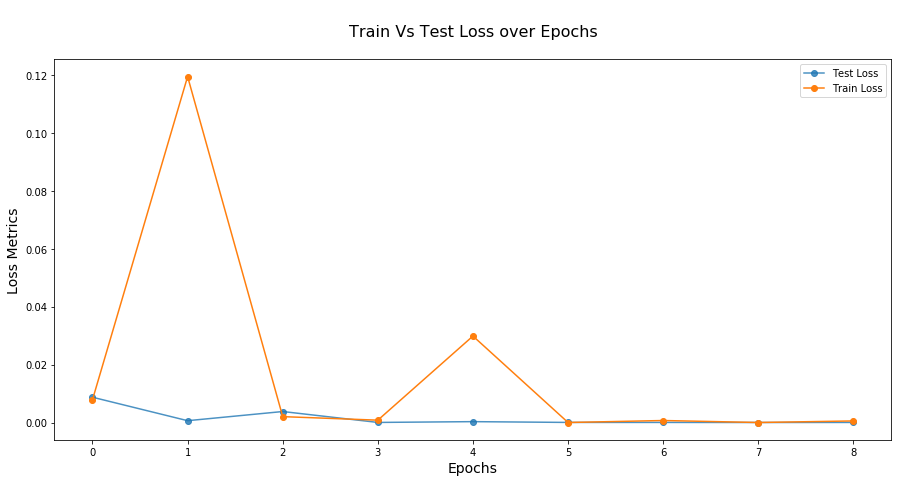

In [17]:
plt.figure(figsize=(15,7))
plt.plot([t for t in test_loss], label='Test Loss',marker='o',alpha=0.8)
plt.plot([t for t in train_loss], label='Train Loss',marker='o')
plt.title('\nTrain Vs Test Loss over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss Metrics',fontsize=14)
plt.legend();

# Save the Model

In [18]:
torch.save(model.state_dict(), 'MNIST_CNN.pt')